*First compiled on: December 3, 2016.*

# Simulating myeloid progenitors

In [1]:
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
# we will soon provide an update with more recent dependencies
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0.3.2 on 2017-11-29 23:03.
Dependencies: numpy==1.13.3 scipy==1.0.0 pandas==0.21.0 scikit-learn==0.18.2 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.5.2+274.g35181a7 


Here, we simulate data using a literature-curated boolean gene
regulatory network, which is believed to describe myeloid differentiation
([Krumsiek *et al.*, 2011](https://doi.org/10.1371/journal.pone.0022649)). Using [sim](https://github.com/theislab/scanpy/tree/master/scanpy/tools/sim.py), the
[boolean model](https://github.com/theislab/scanpy/tree/master/scanpy/sim_models/krumsiek11.txt)
```
Gata2 = Gata2 and not (Gata1 and Fog1) and not Pu.1
Gata1 = (Gata1 or Gata2 or Fli1) and not Pu.1
Fog1 = Gata1
EKLF = Gata1 and not Fli1
Fli1 = Gata1 and not EKLF
SCL = Gata1 and not Pu.1
Cebpa = Cebpa and not (Gata1 and Fog1 and SCL)
Pu.1 = (Cebpa or Pu.1) and not (Gata1 or Gata2)
cJun = Pu.1 and not Gfi1
EgrNab = (Pu.1 and cJun) and not Gfi1
Gfi1 = Cebpa and not EgrNab
```
is translated into a stochastic differential equation ([Wittmann *et al.*, 2009](#ref_wittmann09)). Simulations result
in branching time series of gene expression, where each branch corresponds to a
certain cell fate of common myeloid progenitors (megakaryocytes, erythrocytes,
granulocytes and monocytes).

Instead of simulating the data as in the next line, you can also retrieve it from the builtin examples
```
adata = sc.datasets.krumsiek11()
```

In [2]:
adata = sc.tl.sim('krumsiek11')

reading params file /Users/alexwolf/hholtz/01_projects/1512_scanpy/scanpy/scanpy/sim_models/krumsiek11_params.txt
reading simulation results ./write/krumsiek11_sim/sim_000007.txt


In [3]:
sc.write('krumsiek11', adata)

Plot the four realizations of time series.

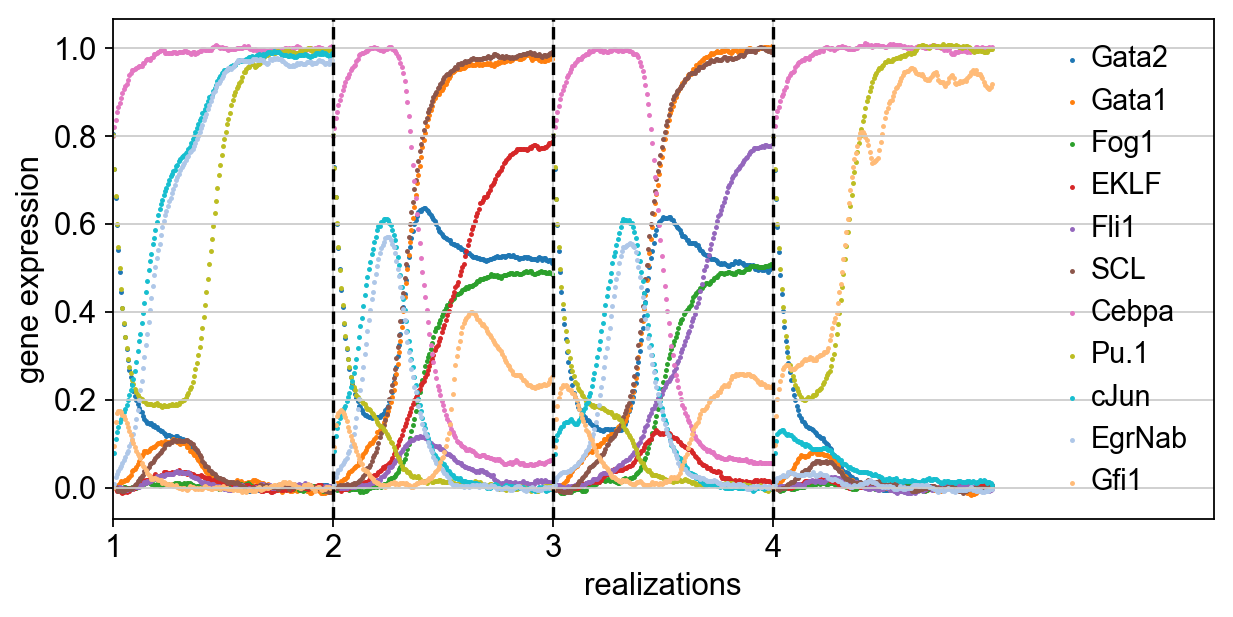

In [4]:
adata = sc.read('krumsiek11')
sc.pl.sim(adata)

Compute further visualizations.

In [5]:
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)
sc.write('krumsiek11', adata)

computing tSNE
    using data matrix X directly (no PCA)
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:01.469):  added
    "X_tsne", tSNE coordinates (adata.smp)
drawing single-cell graph using layout "fr"
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 30 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9984187484  0.9969584346  0.9920812845  0.9909051061
      0.982462585   0.9651808739  0.9614251256  0.9520589113  0.9385533333
      0.9172905087  0.9089729786  0.8958995342  0.8761984706  0.8536655903]
    finished (0:00:03.666) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_params", the parameters (adata.uns)


Inspecting the genes of the fixed poitns, we can make the following annotation.

In [6]:
adata = sc.read('krumsiek11')
fate_labels = {0: 'progenitor', 159: 'monocyte', 319: 'erythrocyte', 
               459: 'megacaryocyte', 619: 'neutrophil'}
adata.uns['highlights'] = fate_labels
cell_type = np.array(['progenitor' for i in range(adata.n_smps)])                                                                                                               
cell_type[80:160] = 'monocyte'                                                                                                                                                  
cell_type[240:320] = 'erythrocyte'                                                                                                                                              
cell_type[400:480] = 'megakaryocyte'                                                                                                                                            
cell_type[560:640] = 'neutrophil'
adata.smp['cell_type'] = cell_type

... storing cell_type as categorical type
--> access categories as adata.smp.cell_type.cat.categories


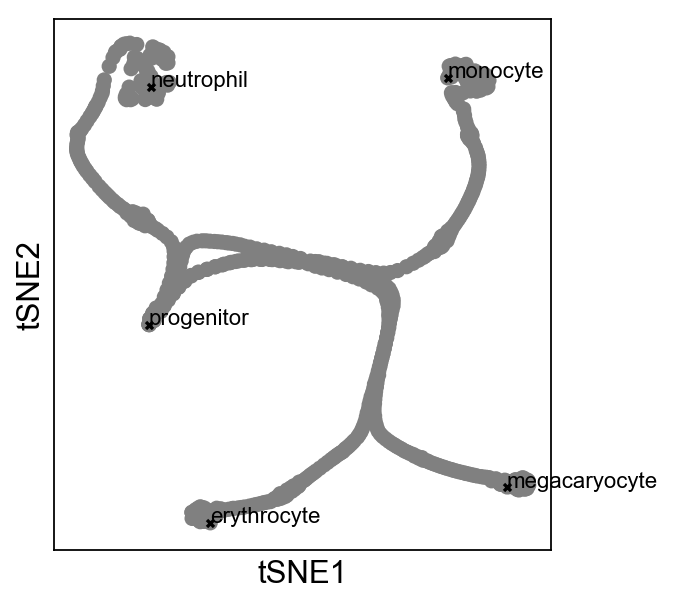

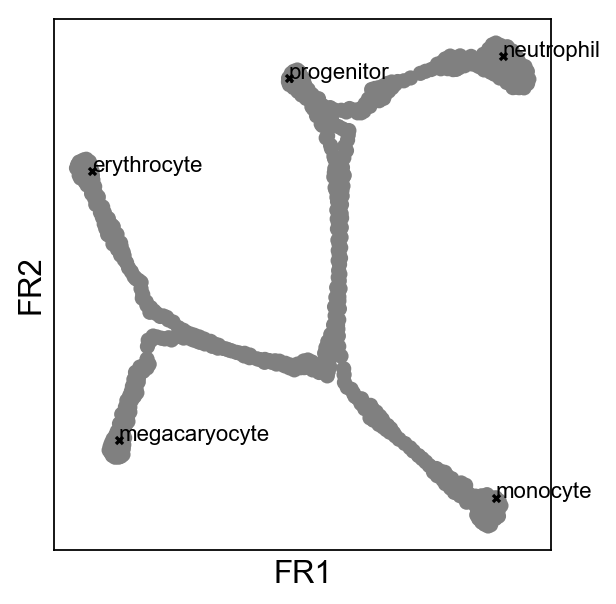

In [7]:
ax = sc.pl.tsne(adata)
ax = sc.pl.draw_graph(adata)

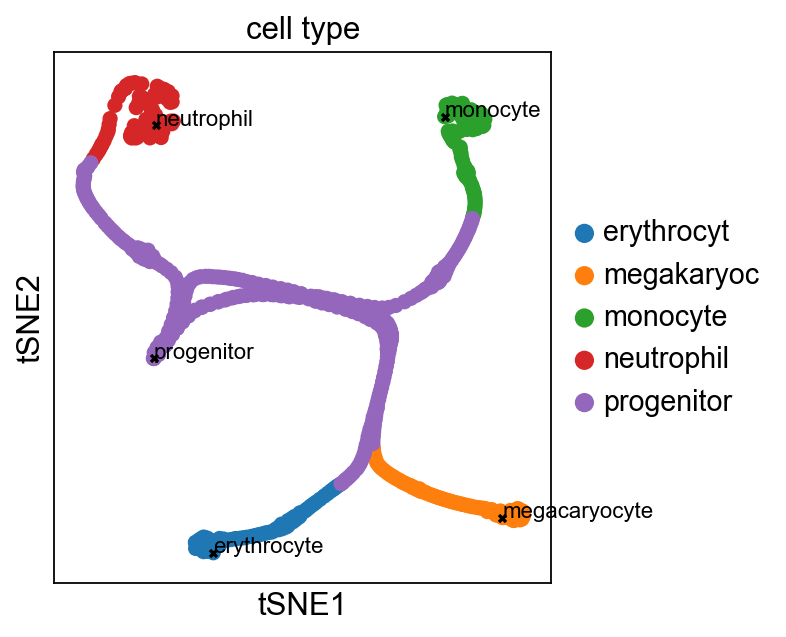

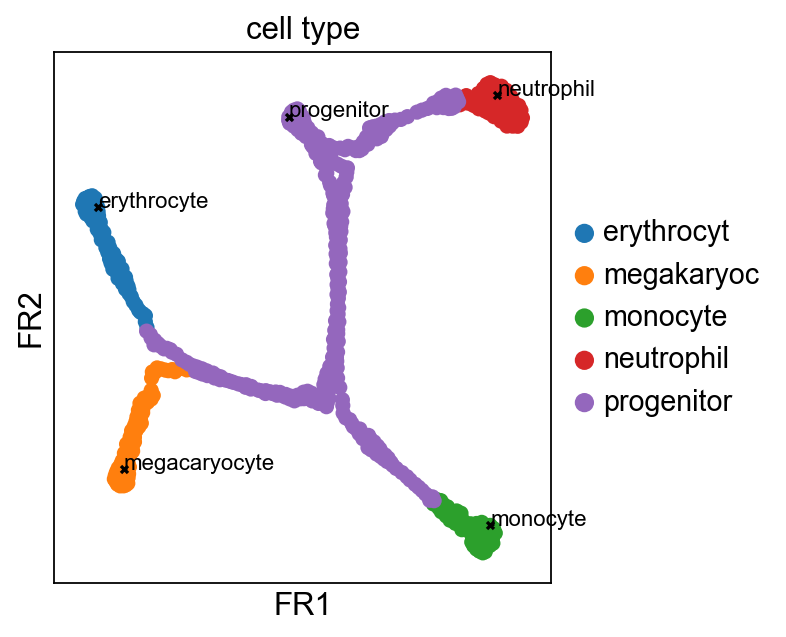

In [8]:
ax = sc.pl.tsne(adata, color='cell_type')
ax = sc.pl.draw_graph(adata, color='cell_type')

### Reconstructing progression and branching using DPT

In [9]:
adata.uns['iroot'] = 0
sc.tl.dpt(adata, n_branchings=2, n_neighbors=5, knn=False)

perform Diffusion Pseudotime analysis
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 5 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            0.9999370575  0.9999125004  0.9998248816  0.9997677207
      0.9993129373  0.9989748597  0.9986642003  0.9982343912  0.99806422  ]
    this uses a hierarchical implementation
    detect 2 branchings
    do not consider groups with less than 6 points for splitting
    branching 1: split group 0
    branching 2: split group 0
finished (0:00:01.089) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


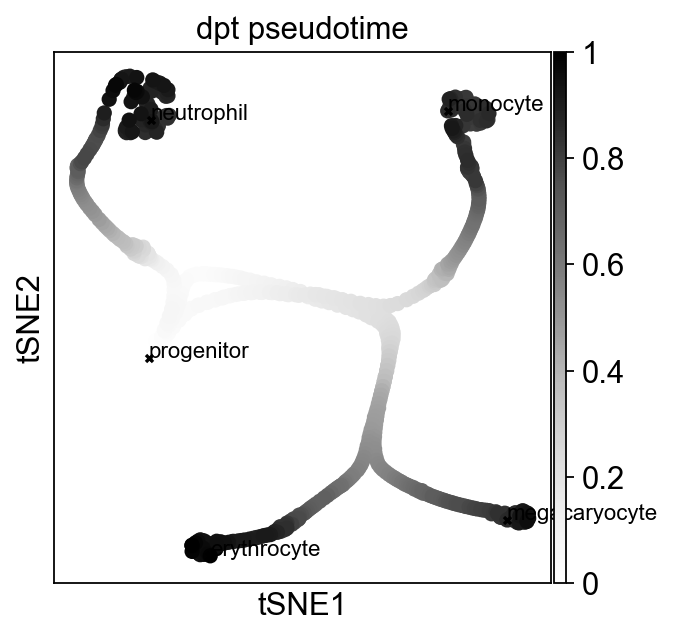

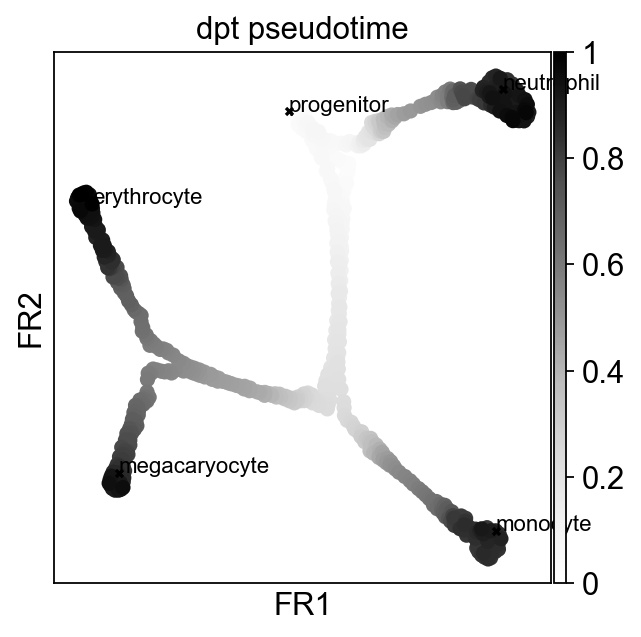

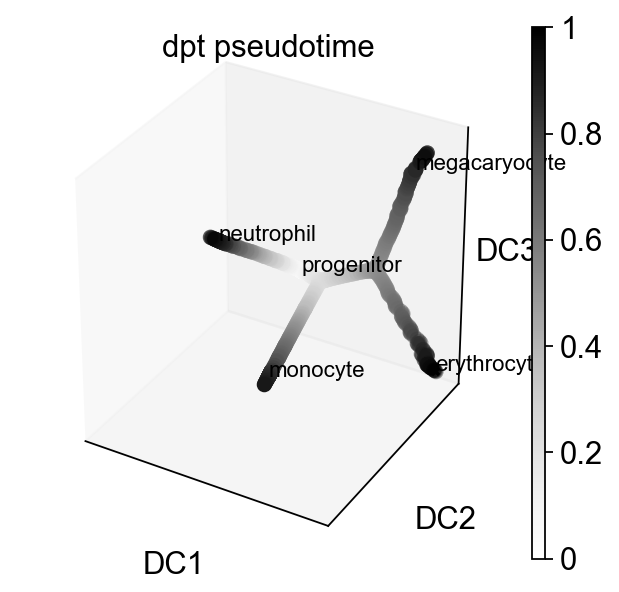

In [10]:
ax = sc.pl.tsne(adata, color='dpt_pseudotime')
ax = sc.pl.draw_graph(adata, color='dpt_pseudotime')
ax = sc.pl.diffmap(adata, color='dpt_pseudotime', projection='3d')

In the diffusion maps visualization, the "cuts" into branches are at meaningful positions. In tSNE and FR, they appear quite arbitrary.

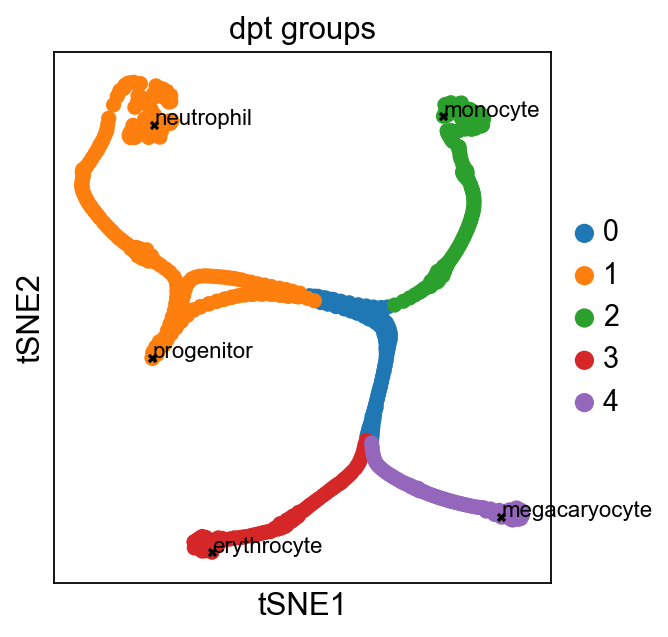

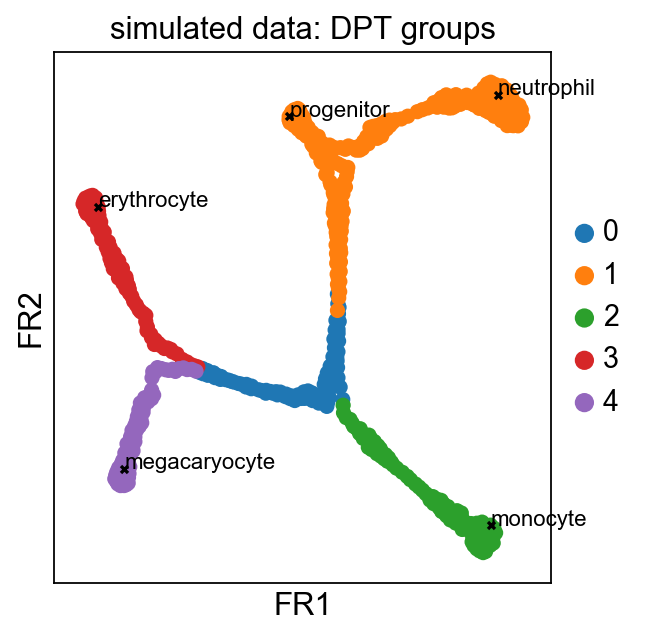

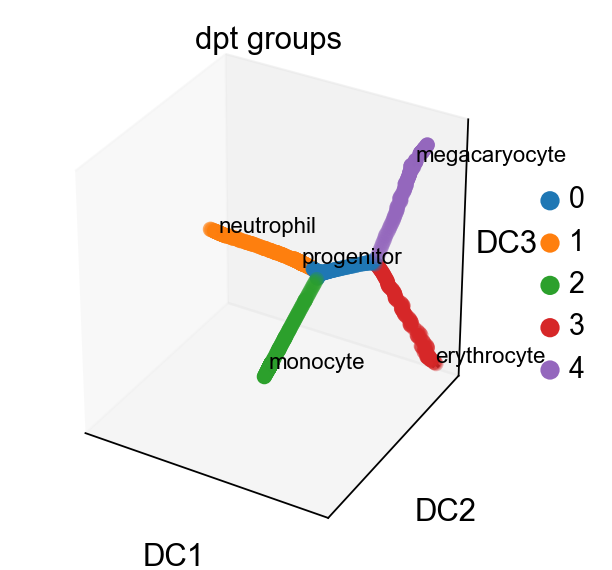

In [11]:
ax = sc.pl.tsne(adata, color='dpt_groups')
ax = sc.pl.draw_graph(adata, color='dpt_groups', title='simulated data: DPT groups')
ax = sc.pl.diffmap(adata, color='dpt_groups', projection='3d')